
# Parallel Multiobjective PSO Weighted Average Clustering Algorithm Implementation
Based on Ling, Huidong, et al. "A Parallel Multiobjective PSO Weighted Average Clustering Algorithm Based on Apache Spark." Entropy 25.2 (2023): 259.

## Algorithm Outline

 

## Adaptations made to suggested implementation of the algorithm:
1. 

## Description of production cluster:



Datasets: https://cs.joensuu.fi/sipu/datasets/

In [1]:
import os
import requests
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean

In [2]:
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import split, col, size, trim, lit
from sklearn.cluster import KMeans


# Initialize a Spark session
spark = SparkSession.builder \
    .appName("FirstSparkJob") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/16 13:11:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Cluster and data Parameters
np.random.seed(301191)
num_clusters = 50
num_partitions = 20

In [4]:
A3_DATASET_URL = "https://cs.joensuu.fi/sipu/datasets/a3.txt"
DATA_FOLDER = "/home/jovyan/work/data"
A3_LOCAL_PATH = os.path.join(DATA_FOLDER, "a3.txt")

# Download Data
if not os.path.exists(A3_LOCAL_PATH):
    with open(A3_LOCAL_PATH, 'wb') as file:
        response = requests.get(A3_DATASET_URL)
        file.write(response.content)

# Load clean data into spark
data = sc.textFile(A3_LOCAL_PATH)
parsed_data = data.map(lambda row: np.array([float(x) for x in row.strip().split()])).repartition(num_partitions).cache()

parsed_data.take(5)

[array([49313., 41972.]),
 array([55194., 44097.]),
 array([55109., 41603.]),
 array([53142., 43422.]),
 array([53656., 41913.])]

In [5]:
# Algorithm parameters, taken from the paper page 9
c1 = c2 = 1.49445    # Learning parameters
w = 3                # Weight factor
num_particles = 5    # Particles number
archive_depth = 15   # Number of items in the archive
num_iterations = 10

dimensions = len(parsed_data.take(1)[0])
num_samples = parsed_data.count()

In [6]:
# Minimum-Maximum Creation using mapPartitions and vectorization
def minimum_maximum_creation(data_rdd, num_clusters):
    # Collect the first centroid randomly
    first_centroid = data_rdd.takeSample(False, 1)[0]
    centroids = [first_centroid]
    
    for _ in range(1, num_clusters):
        # Broadcast the current centroids to all worker nodes
        centroids_bc = sc.broadcast(centroids)
        
        # Calculate minimum distances from each point to the nearest centroid in a partitioned, vectorized manner
        def calculate_distances(partition):
            current_centroids = centroids_bc.value
            partition = list(partition)
            if not partition:
                return iter([])

            partition_array = np.array(partition)
            min_distances = np.min(
                np.array([np.linalg.norm(partition_array - centroid, axis=1) for centroid in current_centroids]), axis=0
            )
            max_distance_point = partition_array[np.argmax(min_distances)]
            return iter([max_distance_point])
        
        # Find the point with the maximum minimum distance from all partitions
        max_distance_point = data_rdd.mapPartitions(calculate_distances).reduce(
            lambda a, b: a if np.linalg.norm(a - centroids[-1]) > np.linalg.norm(b - centroids[-1]) else b
        )
        
        # Append the new centroid
        centroids.append(max_distance_point)
        
        # Unpersist the broadcast variable to free up memory
        centroids_bc.unpersist()
    
    return np.array(centroids)

# Updated initialize_particles function
def initialize_particles(data_rdd, num_particles, num_clusters, num_features):
    particles = []

    timer = time.time()

    for particle_ix in range(num_particles):
        # Use minimum-maximum creation to get initial centroids for each particle
        print(f"{time.time() - timer}\tInitializing particle {particle_ix}")
        initial_centroids = minimum_maximum_creation(data_rdd, num_clusters)
        
        particle = {
            'position': initial_centroids,
            'velocity': np.random.rand(num_clusters, num_features),
            'pbest_position': initial_centroids.copy(),
            'pbest_value': np.array([float('inf'), float('inf')])
        }
        particles.append(particle)
    
    return particles


particles = initialize_particles(parsed_data, num_particles, num_clusters, dimensions)
particles_bc = sc.broadcast(particles)



7.152557373046875e-07	Initializing particle 0


28.91610050201416	Initializing particle 1


56.87876272201538	Initializing particle 2


85.99183130264282	Initializing particle 3


114.3809084892273	Initializing particle 4


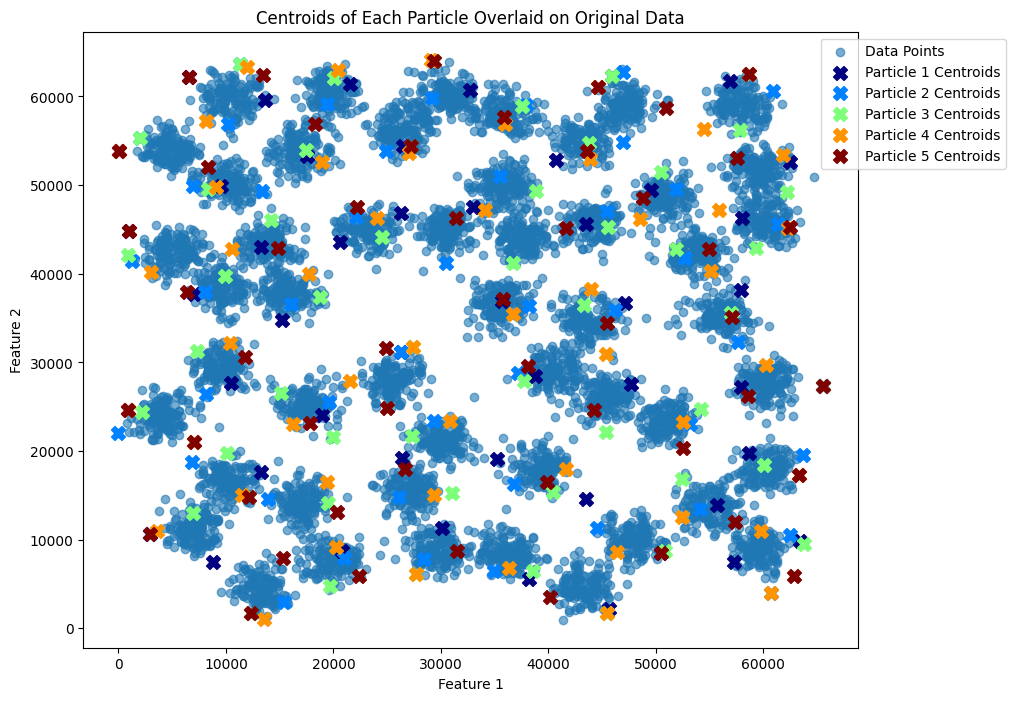

In [7]:
data_points = np.array(parsed_data.collect()) 

num_particles = len(particles)

# Plot the original dataset
plt.figure(figsize=(10, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], label='Data Points', alpha=0.6)

# Plot centroids of each particle
colors = plt.cm.jet(np.linspace(0, 1, num_particles))
for i, particle in enumerate(particles):
    centroids = particle['position']
    plt.scatter(centroids[:, 0], centroids[:, 1], color=colors[i], marker='X', s=100, label=f'Particle {i + 1} Centroids')

# Plot customization
plt.title('Centroids of Each Particle Overlaid on Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [ ]:
def dominates(fitness1, fitness2):
    """Returns True if fitness1 dominates fitness2."""
    return all(f1 <= f2 for f1, f2 in zip(fitness1, fitness2)) and any(f1 < f2 for f1, f2 in zip(fitness1, fitness2))

# Function to calculate the crowding distance for each particle in the archive
def calculate_crowding_distance(pareto_front):
    num_objectives = len(pareto_front[0]['pbest_value'])
    distances = [0] * len(pareto_front)

    for m in range(num_objectives):
        # Sort solutions based on the current objective
        pareto_front.sort(key=lambda x: x['pbest_value'][m])
        
        # Assign infinite distance to boundary solutions
        distances[0] = distances[-1] = float('inf')

        # Find the min and max objective values for normalization
        min_value = pareto_front[0]['pbest_value'][m]
        max_value = pareto_front[-1]['pbest_value'][m]

        # Calculate the crowding distance for the solutions in between
        for i in range(1, len(pareto_front) - 1):
            if max_value - min_value == 0:
                distances[i] += 0
            else:
                distances[i] += (pareto_front[i + 1]['pbest_value'][m] - pareto_front[i - 1]['pbest_value'][m]) / (max_value - min_value)

    # Assign the calculated distances back to the particles
    for i, particle in enumerate(pareto_front):
        particle['crowding_distance'] = distances[i]

    return pareto_front

# Find non-dominated solutions and update the archive with crowding distance
def update_archive(archive, particles):
    combined_solutions = archive + [{'position': p['position'], 'pbest_value': p['pbest_value']} for p in particles]
    pareto_front = []

    for i, solution in enumerate(combined_solutions):
        is_dominated = False
        for j, other_solution in enumerate(combined_solutions):
            if i != j and dominates(other_solution['pbest_value'], solution['pbest_value']):
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(solution)

    # Calculate crowding distance and sort based on it
    pareto_front = calculate_crowding_distance(pareto_front)
    pareto_front.sort(key=lambda x: -x['crowding_distance'])  # Sort by highest crowding distance

    # Optionally, limit the size of the archive if needed
    return pareto_front[:archive_depth]

def compute_fitness(data_partition, particle_position):
    fitness_compactness = 0
    fitness_connectivity = 0
    cluster_assignments = []

    for point in data_partition:
        distances = [euclidean(point, centroid) for centroid in particle_position]
        assigned_cluster = np.argmin(distances)
        cluster_assignments.append((assigned_cluster, point))
        fitness_compactness += distances[assigned_cluster]

    for i, (cluster, point) in enumerate(cluster_assignments):
        if i < len(cluster_assignments) - 1:
            next_point = cluster_assignments[i + 1][1]
            fitness_connectivity += euclidean(point, next_point)

    return fitness_compactness, fitness_connectivity

def calculate_local_fitness(data_partition, particles_bc):
    particles = particles_bc.value
    local_fitness = []
    data_partition = list(data_partition)

    for particle in particles:
        kmeans = KMeans(n_clusters=num_clusters, init=particle['position'], n_init=1, max_iter=10)
        kmeans.fit(data_partition)
        
        compactness = 0
        for i, center in enumerate(kmeans.cluster_centers_):
            points_in_cluster = [point for idx, point in enumerate(data_partition) if kmeans.labels_[idx] == i]
            compactness += sum(euclidean(point, center) for point in points_in_cluster)

        connectivity = 0
        for i, point in enumerate(data_partition[:-1]):
            connectivity += euclidean(point, data_partition[i + 1])

        local_fitness.append((compactness, connectivity))

    return [local_fitness]

def aggregate_fitness(local_fitness_rdd, num_samples):
    fitness_values = local_fitness_rdd.collect()
    weighted_fitness = np.average(fitness_values, axis=0, weights=[partition_size / num_samples for partition_size in [len(f) for f in fitness_values]])
    return weighted_fitness

def update_particles(particles, global_best_position):
    for particle in particles:
        for cluster in range(num_clusters):
            inertia = w * particle['velocity'][cluster]
            cognitive = c1 * np.random.rand() * (particle['pbest_position'][cluster] - particle['position'][cluster])
            social = c2 * np.random.rand() * (global_best_position[cluster] - particle['position'][cluster])
            particle['velocity'][cluster] = inertia + cognitive + social
            particle['position'][cluster] += particle['velocity'][cluster]
    return particles

timer = time.time()
archive = []  # Initialize the external archive

# Main Optimization Loop
for iteration in range(num_iterations):
    print(f"{time.time() - timer}\tIteration {iteration}")
    
    # Local Fitness Calculation
    local_fitness_rdd = parsed_data.mapPartitions(lambda partition: calculate_local_fitness(partition, particles_bc))
    global_fitness = aggregate_fitness(local_fitness_rdd, num_samples=num_samples)
    print(global_fitness)

    # Update pbest for each particle
    for particle in particles:
        if dominates(global_fitness, particle['pbest_value']):
            particle['pbest_position'] = particle['position']
            particle['pbest_value'] = global_fitness

    # Update the external archive
    archive = update_archive(archive, particles)

    # Select the global best particle from the archive (using a heuristic, e.g., random selection)
    global_best_particle = np.random.choice(archive)
    global_best_position = global_best_particle['position']

    # Update particle positions and velocities
    particles = update_particles(particles, global_best_position)

    # Broadcast updated particles
    particles_bc = sc.broadcast(particles)

# Print final archive
print("Final Archive (Pareto Front):")
for solution in archive:
    print(solution['pbest_value'])

# Stopping Spark Context
# sc.stop()

0.00016069412231445312	Iteration 0


[[ 588239.73055714 1408947.81853454]
 [ 574874.03553147 1408947.81853454]
 [ 572741.653456   1408947.81853454]
 [ 584078.72497435 1408947.81853454]
 [ 586595.54561184 1408947.81853454]]


24/11/16 22:27:47 ERROR TaskSchedulerImpl: Lost executor 2 on 172.18.0.3: worker lost: Not receiving heartbeat for 60 seconds
24/11/16 22:27:47 ERROR TaskSchedulerImpl: Lost executor 1 on 172.18.0.5: worker lost: Not receiving heartbeat for 60 seconds
24/11/16 22:27:47 ERROR TaskSchedulerImpl: Lost executor 0 on 172.18.0.6: worker lost: Not receiving heartbeat for 60 seconds
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_6 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_5 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_17 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_9 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_15 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_6_3 !
24/11/16 22:27:47 WARN BlockManagerMasterEndpoint: No more replicas 

In [ ]:
local_fitness_rdd = parsed_data.mapPartitions(lambda partition: calculate_local_fitness(partition, particles_bc))
r  = local_fitness_rdd.collect()

In [ ]:
len(r)